## Классификация цветных изображений на 2 класса: есть самолет/нет самолета

In [1]:
import glob
import numpy as np
import os
import os.path as path
import imageio
from scipy import misc
from keras.models import Sequential, save_model
from keras.layers import Activation, Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import tarfile

/tmp/ipython-input-3516523656.py:6: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


## Загрузка обучающей выборки

Датасет: https://yadi.sk/d/lisBiFiF3kTiEw (копируем в сессионное хранилище)

In [3]:
with tarfile.open("planesnet.tar.gz", "r:gz") as tar:
    tar.extractall(path="planesnet")

/tmp/ipython-input-74133572.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="planesnet")


In [5]:
# IMAGE_PATH should be the path to the planesnet folder
file_paths = glob.glob(path.join('planesnet/planesnet', '*.png'))

In [ ]:
# Список файлов. Первый символ имени файла - класс: 0 - нет самолета, 1 - есть
file_paths

['planesnet/planesnet/0__20170101_201603_0c22__-118.350570409_34.0448543955.png',
 'planesnet/planesnet/0__20160809_180216_0e0d__-121.8798611040226_37.336745349436015.png',
 'planesnet/planesnet/0__20170312_180111_1029__-121.606296321_38.6744276023.png',
 'planesnet/planesnet/0__20170210_174601_0e14__-117.075485481_32.7672025642.png',
 'planesnet/planesnet/1__20160829_195808_0c72__-121.929459635_37.3684506654.png',
 'planesnet/planesnet/0__20170721_175019_1004__-118.45816582989862_33.975883371838115.png',
 'planesnet/planesnet/1__20170618_173641_0c38__-118.40335356269328_33.94712288559425.png',
 'planesnet/planesnet/1__20170626_174403_1025__-117.20469014474084_32.73287298252868.png',
 'planesnet/planesnet/0__20151018_203212_0b0a__-118.39624331570093_33.8786390341951.png',
 'planesnet/planesnet/0__20170528_174533_0f18__-117.576405577_34.032280668.png',
 'planesnet/planesnet/0__20161006_175114_0e1f__-119.139326137_34.1126950077.png',
 'planesnet/planesnet/0__20161116_180805_0e14__-122.38

In [6]:
# Load the images
images = [imageio.imread(i_path) for i_path in file_paths]
images = np.asarray(images)

/tmp/ipython-input-1965676624.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(i_path) for i_path in file_paths]


In [7]:
images.shape

(32000, 20, 20, 3)

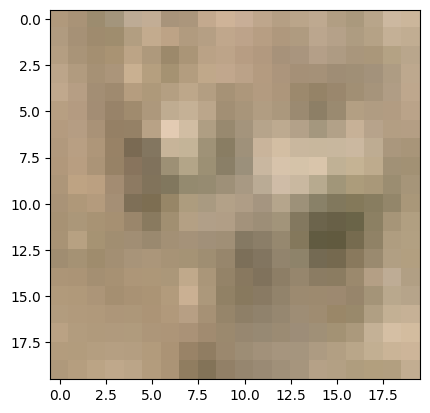

In [8]:
plt.imshow(images[30402]);

In [9]:
# Get image size
image_size = np.asarray([images.shape[1], images.shape[2], images.shape[3]])

In [10]:
image_size

array([20, 20,  3])

In [11]:
# Нормализация
images = images / 255

## Обработка обучающей выборки

Если изображения не рассортированы на классы по поддиректориям и не разделены на обучающие и тестовые, то нужно написать алгоритм их обработки. Если рассортированы, то это не нужно.

In [12]:
n_images = images.shape[0]
labels = np.zeros(n_images)

In [13]:
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [14]:
labels[:30]

array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.])

In [15]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.9

In [16]:
# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

In [17]:
# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]

## Создание и обучение модели

In [19]:
## MODEL CREATION ##
N_LAYERS = 3      # 3 сверточных слоя

# Define model hyperparamters
KERNEL = (3, 3)

# Determine the number of filters in each convolutional layer
filters = [20, 60, 100]

In [20]:
# Define model
model = Sequential()
model.add(Input(shape=(20, 20, 3)))  # 3-я размерность = 3 для цветных изображений
# Add convolutional layers
for i in range(0, N_LAYERS):
    model.add(Conv2D(filters[i], KERNEL))
    # Активацию в Keras можно указывать параметром activation='relu' в предыдущей строке,
    # а можно добавлять отдельным слоем Activation после добавленного слоя
    model.add(Activation('relu'))

model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
# Выходной слой. При бинарной классификации можно использовать 1 выходной нейрон с активацией sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [21]:
# Compile the model
# При бинарной классификации используем loss='binary_crossentropy'
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 18, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 18, 18, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 60)     │        10,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 100)    │        54,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4900)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       735,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,821 (3.05 MB)

 Trainable params: 800,821 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
## MODEL TRAINING ##
# Training Hyperparamters
EPOCHS = 20
BATCH_SIZE = 200

# Train the model
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
             validation_data = [x_test, y_test])

Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7534 - loss: 0.5629 - val_accuracy: 0.8506 - val_loss: 0.3558
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8525 - loss: 0.3286 - val_accuracy: 0.8969 - val_loss: 0.2617
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9075 - loss: 0.2349 - val_accuracy: 0.9269 - val_loss: 0.2060
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9208 - loss: 0.2012 - val_accuracy: 0.9341 - val_loss: 0.1697
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9374 - loss: 0.1632 - val_accuracy: 0.9441 - val_loss: 0.1470
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9434 - loss: 0.1497 - val_accuracy: 0.9372 - val_loss: 0.1487
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9458 - loss: 0.1444 - val_accuracy: 0.9481 - val_loss: 0.1335
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9489 - loss: 0.1315 - val_accuracy: 

In [24]:
## MODEL EVALUATION ##
# Make a prediction on the test set
test_predictions = model.predict(x_test)
test_predictions = np.round(test_predictions)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.970625


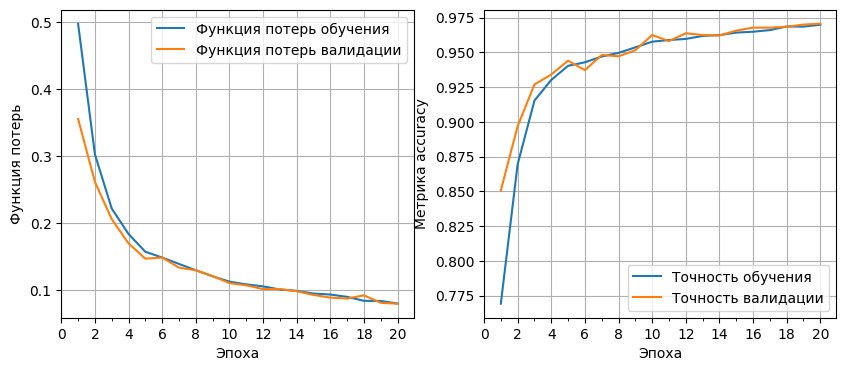

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.arange(1, EPOCHS + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, EPOCHS + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, EPOCHS + 1, 2))
axs[0].set_xticks(np.arange(0, EPOCHS + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, EPOCHS + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, EPOCHS + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, EPOCHS + 1, 2))
axs[1].set_xticks(np.arange(0, EPOCHS + 1, 1), minor=True)
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.show()